In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Load and prepare circular dataset
data = pd.read_csv('circle_dataset.csv')
X = data[['x1', 'x2']].values
y = data['label'].values

# Split and normalize data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
class LogisticRegression:
    def __init__(self, lr=0.1, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        n_classes = len(np.unique(y))
        n_features = X.shape[1]
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros(n_classes)
        y_one_hot = np.eye(n_classes)[y]

        for _ in range(self.epochs):
            z = X @ self.W + self.b
            probs = self.softmax(z)
            error = probs - y_one_hot
            self.W -= self.lr * (X.T @ error) / len(X)
            self.b -= self.lr * np.mean(error, axis=0)

    def predict(self, X):
        return np.argmax(X @ self.W + self.b, axis=1)

# Train and evaluate
lr = LogisticRegression(lr=0.1, epochs=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")


Logistic Regression Accuracy: 0.3133


In [ ]:
class ANN:
    def __init__(self, input_size, hidden_size=64, output_size=3,
                 lr=0.001, epochs=5000, batch_size=32):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

        # He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size)
        self.b2 = np.zeros(output_size)

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y_one_hot):
        n_samples = X.shape[0]
        for epoch in range(self.epochs):
            # Mini-batch training
            indices = np.random.permutation(n_samples)
            for i in range(0, n_samples, self.batch_size):
                batch_idx = indices[i:i+self.batch_size]
                X_batch, y_batch = X[batch_idx], y_one_hot[batch_idx]

                # Forward pass
                hidden = self.relu(X_batch @ self.W1 + self.b1)
                scores = hidden @ self.W2 + self.b2
                probs = self.softmax(scores)

                # Backward pass
                error = (probs - y_batch) / self.batch_size
                dW2 = hidden.T @ error
                db2 = np.sum(error, axis=0)
                hidden_error = error @ self.W2.T * (hidden > 0)
                dW1 = X_batch.T @ hidden_error
                db1 = np.sum(hidden_error, axis=0)

                # Update parameters
                self.W2 -= self.lr * dW2
                self.b2 -= self.lr * db2
                self.W1 -= self.lr * dW1
                self.b1 -= self.lr * db1

    def predict(self, X):
        hidden = self.relu(X @ self.W1 + self.b1)
        return np.argmax(hidden @ self.W2 + self.b2, axis=1)

# Train and evaluate
y_train_one_hot = np.eye(3)[y_train]
ann = ANN(input_size=2, hidden_size=64, lr=0.001, epochs=5000)
ann.fit(X_train, y_train_one_hot)
y_pred_ann = ann.predict(X_test)
print(f"ANN Accuracy: {accuracy_score(y_test, y_pred_ann):.4f}")


ANN Accuracy: 1.0000


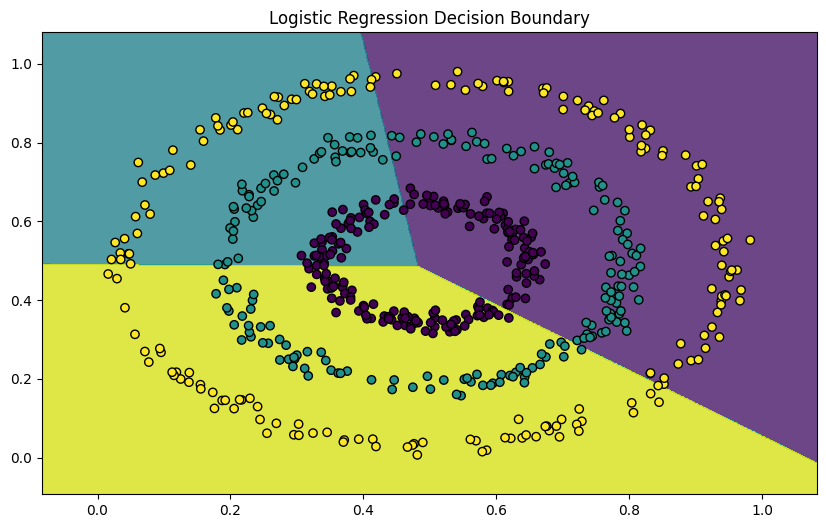

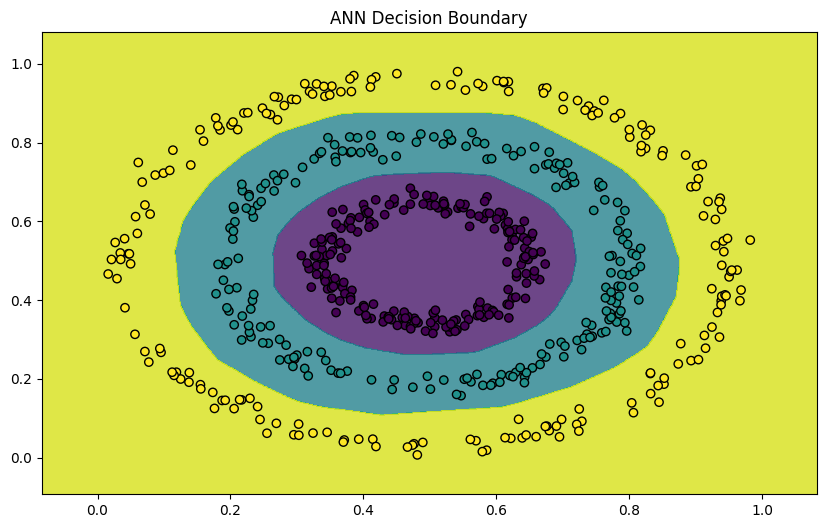

In [ ]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='viridis')
    plt.title(title)
    plt.show()

# Plot boundaries
plot_decision_boundary(lr, X_test, y_test, "Logistic Regression Decision Boundary")
plot_decision_boundary(ann, X_test, y_test, "ANN Decision Boundary")


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate metrics
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

# Evaluate Logistic Regression
accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(y_test, y_pred_lr)

# Evaluate ANN
accuracy_ann, precision_ann, recall_ann, f1_ann = evaluate_model(y_test, y_pred_ann)

# Print comparison
print("Performance Comparison:")
print(f"{'Metric':<10} {'Logistic Regression':<20} {'ANN':<20}")
print(f"{'Accuracy':<10} {accuracy_lr:<20.4f} {accuracy_ann:<20.4f}")
print(f"{'Precision':<10} {precision_lr:<20.4f} {precision_ann:<20.4f}")
print(f"{'Recall':<10} {recall_lr:<20.4f} {recall_ann:<20.4f}")
print(f"{'F1 Score':<10} {f1_lr:<20.4f} {f1_ann:<20.4f}")


Performance Comparison:
Metric     Logistic Regression  ANN                 
Accuracy   0.3133               1.0000              
Precision  0.3131               1.0000              
Recall     0.3133               1.0000              
F1 Score   0.3094               1.0000              
